In [1]:
# Core
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Data Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Reproducibility
import random

# Optional (Augmentation or Visualization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:


# Load the processed data
X_train = np.load('../data/processed/X_train.npy')
y_train = np.load('../data/processed/y_train.npy')

X_val = np.load('../data/processed/X_val.npy')
y_val = np.load('../data/processed/y_val.npy')

X_test = np.load('../data/processed/X_test.npy')
y_test = np.load('../data/processed/y_test.npy')

# Print the shapes of each array
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5712, 128, 128, 3)
y_train shape: (5712, 4)
X_val shape: (655, 128, 128, 3)
y_val shape: (655, 4)
X_test shape: (656, 128, 128, 3)
y_test shape: (656, 4)


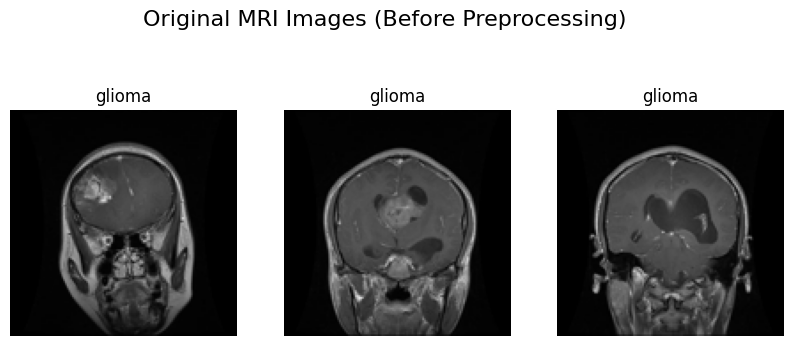

In [3]:

if isinstance(y_train[0], (np.ndarray, list)):
    class_names = ['glioma', 'meningioma', 'pituitary', 'no_tumor']
    y_labels = [class_names[np.argmax(label)] for label in y_train]
else:
    y_labels = y_train

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(y_labels[i])
    plt.axis('off')
plt.suptitle("Original MRI Images (Before Preprocessing)", fontsize=16)
plt.show()


In [4]:
# Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    fill_mode='reflect'
)

# Just rescaling for validation and test data
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
train_generator = train_datagen.flow(
    X_train, y_train, batch_size=32, shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val, batch_size=32, shuffle=False
)

test_generator = test_datagen.flow(
    X_test, y_test, batch_size=32, shuffle=False
)


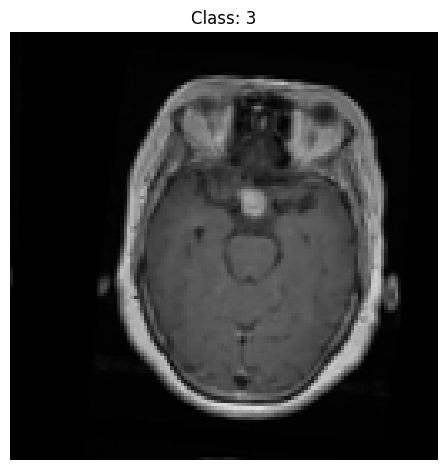

In [6]:
import matplotlib.pyplot as plt

# خد دفعة واحدة من الصور (Batch)
x_batch, y_batch = next(train_generator)
    
   
plt.imshow(x_batch[31])
plt.axis('off')
plt.title(f"Class: {y_batch[31].argmax()}")

plt.tight_layout()
plt.show()


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])
model.summary()

c:\Users\digital\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,092 (16.36 MB)

 Trainable params: 4,288,644 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
from tensorflow.keras.metrics import Precision, Recall
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


In [9]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    '../outputs/base_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [10]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


c:\Users\digital\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4671 - loss: 3.2357 - precision: 0.5579 - recall: 0.3297
Epoch 1: val_loss improved from inf to 21.02192, saving model to ../outputs/base_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.4673 - loss: 3.2273 - precision: 0.5584 - recall: 0.3297 - val_accuracy: 0.2287 - val_loss: 21.0219 - val_precision: 0.2287 - val_recall: 0.2287
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5567 - loss: 1.0179 - precision: 0.7398 - recall: 0.3660
Epoch 2: val_loss improved from 21.02192 to 3.42237, saving model to ../outputs/base_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.5568 - loss: 1.0179 - precision: 0.7397 - recall: 0.3661 - val_accuracy: 0.2790 - val_loss: 3.4224 - val_precision: 0.2838 - val_recall: 0.2591
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6146 - loss: 0.9102 - precision: 0.7496 - recall: 0.4639
Epoch 3: val_loss improved from 3.42237 to 

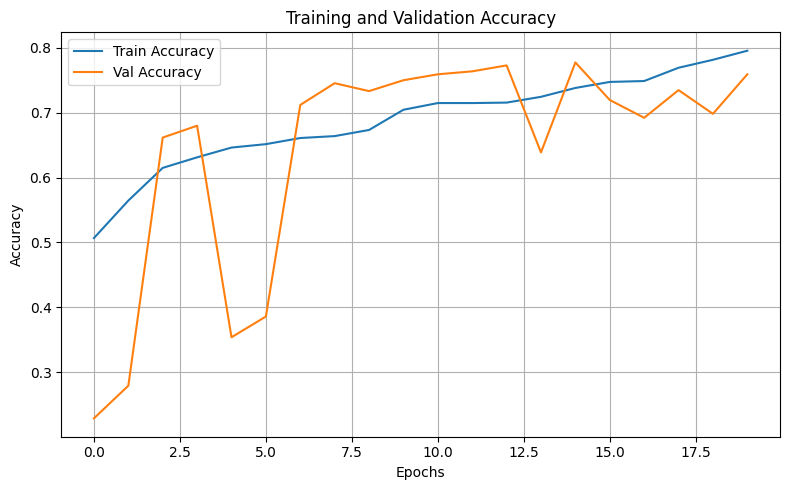

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


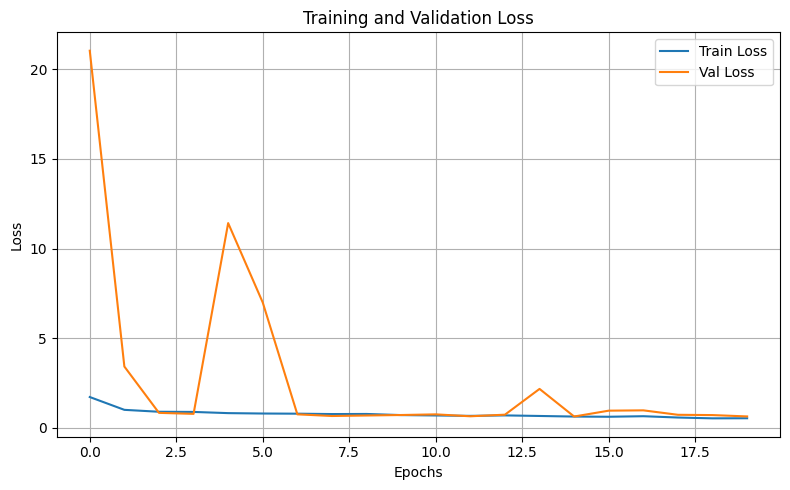

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']


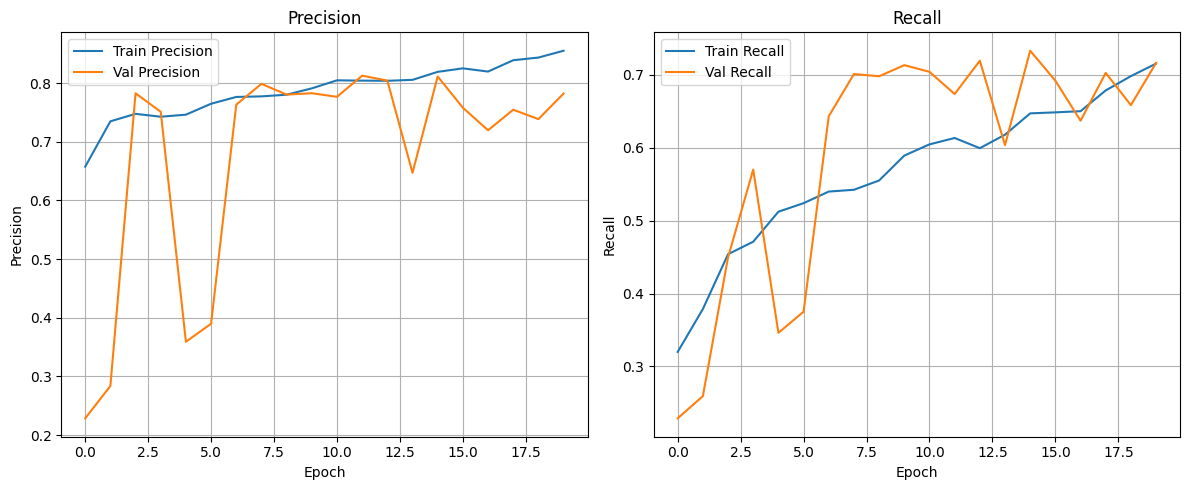

In [14]:

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Precision
axs[0].plot(precision, label='Train Precision')
axs[0].plot(val_precision, label='Val Precision')
axs[0].set_title('Precision')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Precision')
axs[0].legend()
axs[0].grid(True)

# Plot Recall
axs[1].plot(recall, label='Train Recall')
axs[1].plot(val_recall, label='Val Recall')
axs[1].set_title('Recall')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Recall')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



# Build the Transfer Learning Model

In [15]:

from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(input_shape=(128,128,3),include_top=False,weights='imagenet')
base_model.trainable = False #Freeze the pretrained layers
from tensorflow.keras import layers ,models
from keras.layers import Dropout,GlobalAveragePooling2D

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(4,activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
from tensorflow.keras.metrics import Precision, Recall
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    '../outputs/MobileNetV2_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [18]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7448 - loss: 0.6500 - precision: 0.7947 - recall: 0.6838
Epoch 1: val_loss improved from inf to 0.44149, saving model to ../outputs/MobileNetV2_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 462ms/step - accuracy: 0.7452 - loss: 0.6492 - precision: 0.7950 - recall: 0.6843 - val_accuracy: 0.8186 - val_loss: 0.4415 - val_precision: 0.8447 - val_recall: 0.7957
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8680 - loss: 0.3556 - precision: 0.8848 - recall: 0.8493
Epoch 2: val_loss did not improve from 0.44149
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 446ms/step - accuracy: 0.8680 - loss: 0.3556 - precision: 0.8848 - recall: 0.8493 - val_accuracy: 0.8140 - val_loss: 0.4504 - val_precision: 0.8291 - val_recall: 0.7912
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8784 - loss: 0.3257 - precision: 0.8919 - recall: 0.8608
Epoch 3: val_loss improved from 0.44149 to 0.33497, saving model to ../outp

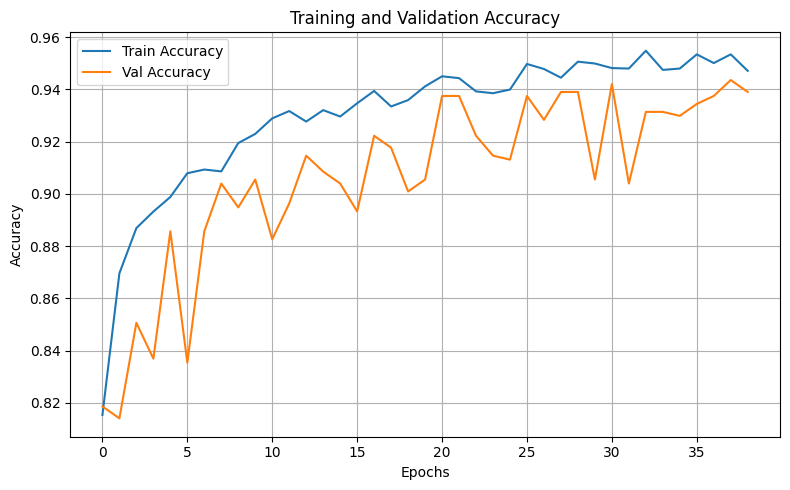

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


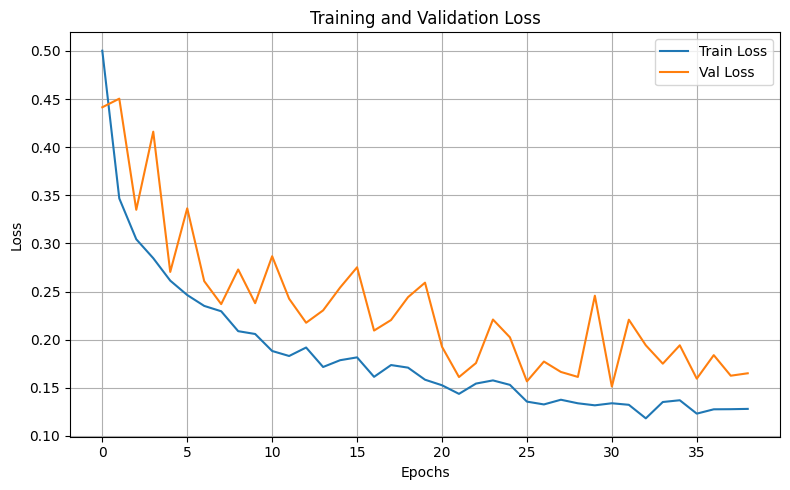

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']


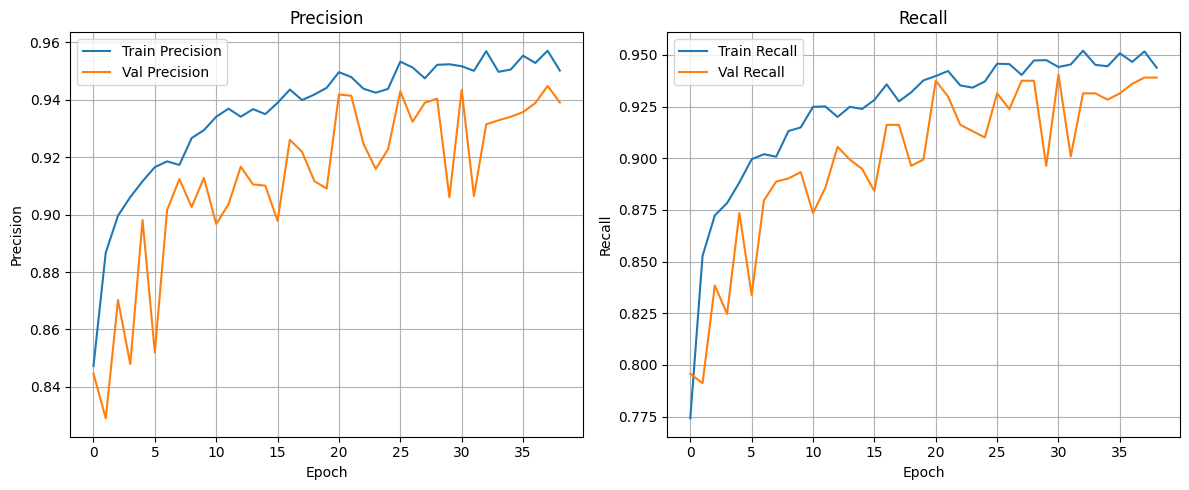

In [22]:

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Precision
axs[0].plot(precision, label='Train Precision')
axs[0].plot(val_precision, label='Val Precision')
axs[0].set_title('Precision')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Precision')
axs[0].legend()
axs[0].grid(True)

# Plot Recall
axs[1].plot(recall, label='Train Recall')
axs[1].plot(val_recall, label='Val Recall')
axs[1].set_title('Recall')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Recall')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Evaluate on Test Set (Accuracy & Loss)

In [28]:
# Evaluate model performance on test data

results = model.evaluate(test_generator)

test_loss = results[0]
test_accuracy = results[1]
test_precision = results[2]
test_recall = results[3]

print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Precision     : {test_precision:.4f}")
print(f"Recall        : {test_recall:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 422ms/step - accuracy: 0.9394 - loss: 0.1481 - precision: 0.9407 - recall: 0.9363
Test Loss     : 0.1513
Test Accuracy : 0.9421
Precision     : 0.9434
Recall        : 0.9405


In [29]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predictions
y_true = np.argmax(y_test, axis=1)
y_pred_proba = model.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)

# Print classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 596ms/step

 Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.89      0.92       150
  meningioma       0.86      0.93      0.89       153
   pituitary       0.99      0.99      0.99       203
    no_tumor       0.97      0.95      0.96       150

    accuracy                           0.94       656
   macro avg       0.94      0.94      0.94       656
weighted avg       0.94      0.94      0.94       656



In [30]:
class_names = ['No Tumor', 'Meningioma', 'Glioma', 'Pituitary']


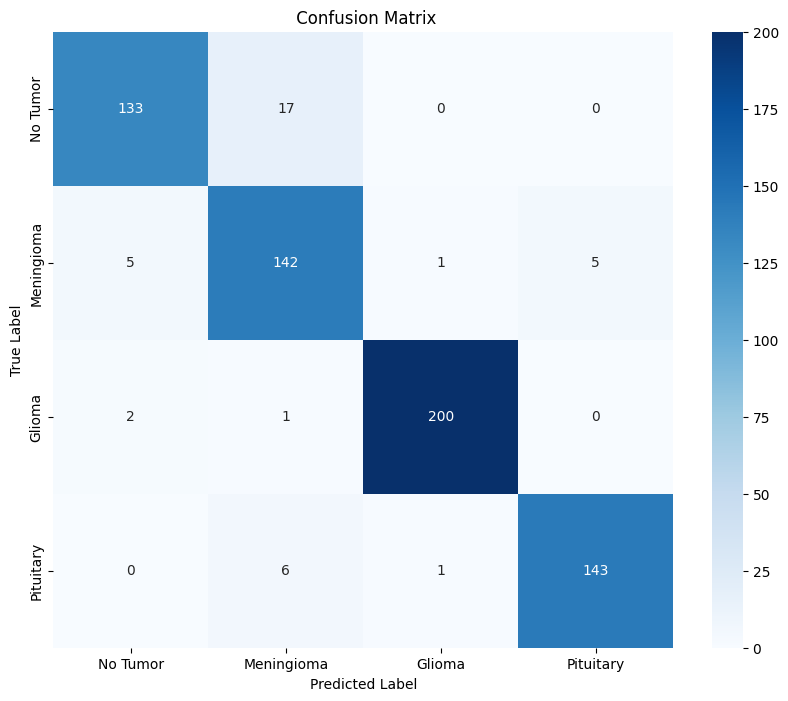

In [32]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(" Confusion Matrix")
plt.show()
